In [33]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [37]:
import sys         
sys.path.append('/home/pranisaa/working_dir/Text-Summarization')
from config import *
import pandas as pd
from datasets import load_dataset
from dataset import Dataset
pd.set_option('display.max_colwidth', None)
import pickle
import numpy as np

import re
import string
import spacy
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords') # run this one time
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pranisaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load dataset

In [36]:
# Load dataset
data = 'xsum'

if data == 'cnn_dailymail':
    dataset = load_dataset(data, '3.0.0')
    source_text = "article"
    target_text = "highlights"
elif data == "xsum":
    dataset = load_dataset(data)
    source_text = "document"
    target_text = "summary"
else:
    raise ValueError("Undefined dataset")

Using custom data configuration default
Reusing dataset xsum (/home/pranisaa/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

### Get Q1 and Q3 dataset

In [5]:
pickle_in = open("val_len_q1_max512.pickle","rb")
example_dict = pickle.load(pickle_in)
q1_id = example_dict['ids']

pickle_in = open("val_len_q3_max512.pickle","rb")
example_dict = pickle.load(pickle_in)
q3_id = example_dict['ids']

In [6]:
df_data = {'id': dataset['validation']['id'], 'document': dataset['validation']['document']}

In [8]:
val_doc_q1 = {'ids': [], 'document': []}
for i, idx in enumerate(df_data['id']):
    if int(idx) in q1_id:
        val_doc_q1['ids'].append(idx)
        val_doc_q1['document'].append(df_data['document'][i])
        
val_doc_q3 = {'ids': [], 'document': []}
for i, idx in enumerate(df_data['id']):
    if int(idx) in q3_id:
        val_doc_q3['ids'].append(idx)
        val_doc_q3['document'].append(df_data['document'][i])

#### Preprocess

In [38]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
    output = []
    for sent in texts:
        doc = nlp(sent) 
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return output

In [39]:
val_q1 = pd.DataFrame.from_dict(val_doc_q3)
val_q1['document'] = val_q1['document'].apply(clean_text)
val_q1['document'] = val_q1['document'].apply(remove_stopwords)
text_list=val_q1['document'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

david miller died house patterdale walk northampton early hours tuesday northamptonshire police said woman fixed address four others charged murder zena kane cuthbertson michael hallett joseph catlin remanded custody northampton crown court
['walk', 'early', 'hour', 'northamptonshire', 'police', 'woman', 'address', 'other', 'murder', 'zena', 'custody']


In [21]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [22]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [23]:
lda_model.print_topics()

[(0,
  '0.011*"year" + 0.008*"police" + 0.007*"attack" + 0.007*"road" + 0.006*"report" + 0.006*"future" + 0.005*"british" + 0.005*"last" + 0.005*"time" + 0.005*"people"'),
 (1,
  '0.013*"police" + 0.008*"year" + 0.007*"building" + 0.007*"incident" + 0.007*"diamond" + 0.006*"public" + 0.005*"work" + 0.005*"place" + 0.005*"store" + 0.004*"time"'),
 (2,
  '0.012*"year" + 0.011*"last" + 0.009*"club" + 0.009*"time" + 0.007*"player" + 0.007*"team" + 0.007*"police" + 0.006*"scottish" + 0.006*"people" + 0.006*"local"'),
 (3,
  '0.011*"year" + 0.006*"last" + 0.006*"people" + 0.006*"defender" + 0.006*"time" + 0.005*"price" + 0.005*"number" + 0.005*"government" + 0.005*"city" + 0.004*"family"'),
 (4,
  '0.011*"people" + 0.008*"year" + 0.006*"comment" + 0.006*"horse" + 0.006*"last" + 0.006*"river" + 0.006*"time" + 0.005*"government" + 0.005*"court" + 0.004*"town"')]

In [24]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/home/pranisaa/thesis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.021051  0.077546       1        1  22.468430
4     -0.117040  0.013685       2        1  22.371791
2     -0.031896 -0.106496       3        1  20.951942
0      0.095353 -0.062844       4        1  19.306078
1      0.074634  0.078110       5        1  14.901759, topic_info=               Term       Freq      Total Category  logprob  loglift
619          attack   9.000000   9.000000  Default  30.0000  30.0000
1839        diamond   6.000000   6.000000  Default  29.0000  29.0000
62           police  36.000000  36.000000  Default  28.0000  28.0000
204            club  16.000000  16.000000  Default  27.0000  27.0000
1493       scottish  10.000000  10.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
47             time   3.777093  36.337878   Topic5  -5.4862  -0.3602
114          people   3.448328  39.450870   Topic5  -5.5772  -0.5335
109   investigation   2.786192  10.709493   Topic5  -5.7905   0.5572
263            many   2.785860  13.720856   Topic5  -5.7906   0.3093
457          family   2.785564  13.733322   Topic5  -5.7907   0.3083

[325 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1957      2  0.810406          abuse
1032      1  0.676880  accommodation
698       4  0.836565           acid
1236      2  0.676457        airport
2195      4  0.696963           ajax
...     ...       ...            ...
53        1  0.256607           year
53        2  0.176417           year
53        3  0.256607           year
53        4  0.208493           year
53        5  0.112265           year

[558 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

In [25]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -6.897256500020775

Coherence Score:  0.3406722088086211


***
Method to find optimal number of topics
Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
***

In [26]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

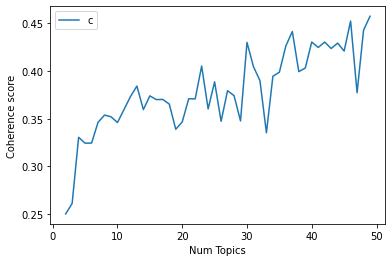

In [28]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2501
Num Topics = 3  has Coherence Value of 0.2611
Num Topics = 4  has Coherence Value of 0.3304
Num Topics = 5  has Coherence Value of 0.3243
Num Topics = 6  has Coherence Value of 0.3245
Num Topics = 7  has Coherence Value of 0.3462
Num Topics = 8  has Coherence Value of 0.3538
Num Topics = 9  has Coherence Value of 0.3521
Num Topics = 10  has Coherence Value of 0.346
Num Topics = 11  has Coherence Value of 0.3595
Num Topics = 12  has Coherence Value of 0.3732
Num Topics = 13  has Coherence Value of 0.3843
Num Topics = 14  has Coherence Value of 0.3596
Num Topics = 15  has Coherence Value of 0.374
Num Topics = 16  has Coherence Value of 0.3701
Num Topics = 17  has Coherence Value of 0.3702
Num Topics = 18  has Coherence Value of 0.3653
Num Topics = 19  has Coherence Value of 0.3389
Num Topics = 20  has Coherence Value of 0.3466
Num Topics = 21  has Coherence Value of 0.3709
Num Topics = 22  has Coherence Value of 0.3708
Num Topics = 23  has Co

In [30]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.009*"people" + 0.009*"year" + 0.007*"time" + 0.006*"last" + 0.006*"defender" + 0.005*"land" + 0.005*"report" + 0.005*"scottish" + 0.004*"police" + 0.004*"patient"'),
 (1,
  '0.010*"year" + 0.008*"area" + 0.008*"tree" + 0.007*"local" + 0.007*"service" + 0.006*"number" + 0.006*"people" + 0.005*"world" + 0.005*"council" + 0.005*"government"'),
 (2,
  '0.011*"year" + 0.009*"police" + 0.008*"price" + 0.006*"high" + 0.005*"last" + 0.005*"figure" + 0.005*"child" + 0.005*"hospital" + 0.004*"average" + 0.004*"patient"'),
 (3,
  '0.012*"year" + 0.011*"time" + 0.008*"last" + 0.006*"horse" + 0.006*"local" + 0.005*"family" + 0.005*"road" + 0.005*"branch" + 0.004*"people" + 0.004*"comment"'),
 (4,
  '0.008*"club" + 0.008*"year" + 0.007*"game" + 0.007*"last" + 0.005*"time" + 0.005*"season" + 0.005*"good" + 0.005*"rover" + 0.005*"national" + 0.004*"people"'),
 (5,
  '0.015*"year" + 0.012*"last" + 0.010*"people" + 0.009*"police" + 0.008*"team" + 0.008*"time" + 0.006*"event" + 0.006*"game" + 0

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

/home/pranisaa/thesis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060884 -0.008379       1        1  18.141311
3      0.067966  0.037149       2        1  16.604044
5     -0.062521 -0.017899       3        1  13.431486
1      0.013173 -0.053130       4        1  10.693487
6      0.060891  0.061813       5        1  10.300632
4      0.051456 -0.095559       6        1   8.766614
7     -0.051981  0.035740       7        1   8.211889
2     -0.020222  0.023654       8        1   6.999647
8      0.002122  0.016611       9        1   6.850888, topic_info=          Term       Freq      Total Category  logprob  loglift
62      police  35.000000  35.000000  Default  30.0000  30.0000
1839   diamond   6.000000   6.000000  Default  29.0000  29.0000
1190      tree   6.000000   6.000000  Default  28.0000  28.0000
1500  defender   9.000000   9.000000  Default  27.0000  27.0000
155      price   7.000000   7.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
175     former   1.256808  11.205741   Topic9  -5.8095   0.4929
114     people   1.605693  40.672799   Topic9  -5.5645  -0.5512
283       road   1.279007  17.308445   Topic9  -5.7920   0.0757
116     report   1.202737  14.221031   Topic9  -5.8534   0.2107
57       early   1.154017  13.031239   Topic9  -5.8948   0.2567

[614 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
875       8  0.785881       abbey
876       8  0.785834  abominable
698       7  0.328066        acid
698       8  0.328066        acid
698       9  0.328066        acid
...     ...       ...         ...
53        7  0.047859        year
53        8  0.079765        year
53        9  0.031906        year
1993      3  0.466818   zealander
64        7  0.745839        zena

[1205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 2, 7, 5, 8, 3, 9])

In [32]:
pyLDAvis.disanable_notebook()

AttributeError: module 'pyLDAvis' has no attribute 'disanable_notebook'

/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
